In [34]:
from os import cpu_count
from collections import OrderedDict
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on {DEVICE} using Pytorch {torch.__version__} and Flower {fl.__version__}")
disable_progress_bar()

Training on cuda using Pytorch 2.2.1+cu121 and Flower 1.7.0


### Loading The Dataset

Loading CIFAR10 dataset and splitting it into 10 different partitions/dataloader which can be considered as 10 different clients/organizations.

In [35]:
NUM_CLIENTS = 2
BATCH_SIZE = 32
NUM_WORKERS = cpu_count()

In [36]:
def load_transform_data():
    # load dataset
    fds = FederatedDataset(dataset='cifar10', partitioners={'train': NUM_CLIENTS})
    
    # image transformation per batch
    def transform_batch(batch):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        # transform batch images
        batch['img'] = [transform(img) for img in batch['img']]
        return batch
    
    # create train/val for each partitioner and load in torch dataloader
    train_loader = []
    val_loader = []
    
    # loading splitted dataset as individual partitions/new datasets
    for partition_id in range(NUM_CLIENTS):
        # load a specific splitted dataset into a partition/as a new dataset
        partition = fds.load_partition(node_id=partition_id, split='train')
        # transformation function for the new dataset/partition batches
        partition = partition.with_transform(transform_batch)
        # create train test split for the new dataset/partition
        partition = partition.train_test_split(
            train_size=0.8,
            test_size=0.2,
            shuffle=True)
        # create train and test dataloader
        train_loader.append(DataLoader(
            dataset=partition['train'],
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            shuffle=True
            ))
        val_loader.append(DataLoader(
            dataset=partition['test'],
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            shuffle=True
            ))
    
    # create a final evaluation dataset and its dataloader
    testset = fds.load_full(split='test').with_transform(transform_batch)
    test_dataloader = DataLoader(dataset=testset,
                                 batch_size=BATCH_SIZE,
                                 num_workers=NUM_WORKERS,
                                 shuffle=True)
    
    # return train, val and test data loaders
    return train_loader, val_loader, test_dataloader

In [37]:
# load cifar10 data
trainloaders, valloaders, testloaders = load_transform_data()

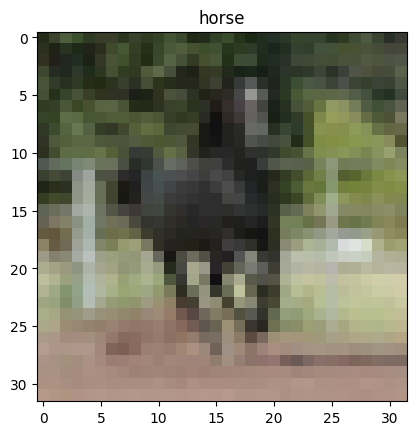

In [38]:
# plot an image from the first partition's first batch

sample = next(iter(trainloaders[0]))
sample_img, labl = sample['img'][0], sample['label'][0]
sample_img = sample_img.permute(1, 2, 0)
plt.imshow(sample_img / 2 + 0.5) # denormalize and plot
plt.title(trainloaders[0].dataset.features['label'].int2str(int(labl)))
plt.show()

### Centralized Training With Pytorch

1. Create a simple CNN model
2. Write train and test function
3. Train the model

In [39]:
# 1. Create a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self,) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 2. Train Test Functions
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.inference_mode():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [40]:
# training the model
trainloader_0 = trainloaders[0]
valloader_0 = valloaders[0]
net = SimpleCNN().to(DEVICE)

# train and val
for epoch in range(5):
    train(net, trainloader_0, 1)
    loss, accuracy = test(net, valloader_0)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

# eval
loss, accuracy = test(net, testloaders)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.04864181287288666, accuracy 0.434
Epoch 2: validation loss 0.04460823554992676, accuracy 0.4832
Epoch 3: validation loss 0.04228813263177872, accuracy 0.511
Epoch 4: validation loss 0.04162742267847061, accuracy 0.5182
Epoch 5: validation loss 0.03921552418470383, accuracy 0.5544
Final test set performance:
	loss 0.03858657919764519
	accuracy 0.5572


### Starting On Federated Learning

Steps:
1. Create helper functions
2. Implement Flower client class
3. Virtual Client Engine

#### Step 1: Helper Functions
Need two helper functions:

1. Send shared model parameters from central server to clients
2. Receive update local model parameters to merge and update the shared model

In [41]:
# set parameter: sending/updating local models with weight from central server.

def set_parameter(model, parameters: List[np.ndarray]) -> None:
    # convert paramaters/numpy arr back to tensors
    param_tensors = [torch.from_numpy(param) for param in parameters]
    # create a state dict from the given parameter
    state_dict = OrderedDict(zip(model.state_dict().keys(), param_tensors))
    # load it into the given model
    model.load_state_dict(state_dict=state_dict, strict=True)
    
# get parameters: receive updated parameter from client
def get_parameter(model) -> List[np.ndarray]:
    # get tensor/parameter from model state dict, shift to cpu and convert to numpy
    return [param_val.cpu().numpy() for _, param_val in model.state_dict().items()]

#### Step 2: Create Client
We can derive from flwr.client.Client or flwr.client.NumpyClient to create clients

In [42]:
class FlowerClientCifar(fl.client.NumPyClient):
    def __init__(self, model, trainloader, valloader) -> None:
        super().__init__()
        self.model = model
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        # return the local model's update parameters to central server
        return get_parameter(self.model)
    
    def fit(self, parameters, config):
        # load the parameters from central server to client's local model
        set_parameter(self.model, parameters)
        # train the local model
        train(self.model, self.trainloader, epochs=1) # training for only 1 epoch
        # return the updated weights to server, number of batches and other stuff
        return get_parameter(self.model), len(self.trainloader), {}
    
    def evaluate(self, parameters, config):
        # load the parameters from central server to client's local model
        set_parameter(self.model, parameters)
        # evaluate on local data
        loss, accuracy = test(self.model, self.trainloader)
        # return the results, number of batches, metrics dictionary
        return float(loss), len(self.valloader), {'accuracy': float(accuracy)}

#### Step 3: Using Virtual Client Engine (Flower VCE)

Using `client_fn` function which creates client instances only when necessary.

In [43]:
def client_fn(cid: str):
    """Creates a flower client instance representing an organization"""

    # load model
    model = SimpleCNN().to(DEVICE)
    # load client's own train & val data
    trainloader_client = trainloaders[int(cid)]
    valloaders_client = valloaders[int(cid)]
    # return a flower client instance
    return FlowerClientCifar(model, trainloader_client, valloaders_client).to_client()

### Step 4: Training

Simulating for 10 clients using CIFAR10 dataset and SimpleCNN architecture using the FedAvg Algorithm

1. Choose strategy (FedAvg for us)
2. Select client resources
3. Metric aggregration function (Flower only aggregates losses returned by individual clients)
4. Start simulation

In [44]:
# 1. Metric aggregation for evaluation
# implemented simple weighted aggregation
def weighted_avg(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # multiply accuracy of each client with num_samples
    accuracies = [num_samp * m['accuracy'] for num_samp, m in metrics]
    samples = [num_samp for num_samp, _ in metrics]

    # return weighted accuracy
    return {'accuracy': sum(accuracies) / sum(samples)}

# 2. strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1, # available client percentage to sample for training
    fraction_evaluate=0.5, # available client percentage to sample for evaluation
    min_fit_clients=2, # min num of clients to sample for training
    min_evaluate_clients=2, # min num of clients to sample for evaluation
    min_available_clients=2, # wait until given clients are available
    evaluate_metrics_aggregation_fn=weighted_avg
)

# 3. client resources
client_resources = {
        'num_cpus' : NUM_WORKERS//NUM_CLIENTS,
        'num_gpus' : 1 if DEVICE.type == 'cuda' else 0
    }
    
# 4. start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients = NUM_CLIENTS,
    strategy=strategy,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=5)
)

INFO flwr 2024-03-07 11:35:43,501 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


2024-03-07 11:35:46,657	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-07 11:35:47,412 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 16.0, 'node:__internal_head__': 1.0, 'object_store_memory': 8308188364.0, 'node:10.255.93.233': 1.0, 'memory': 16616376731.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2024-03-07 11:35:47,412 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-07 11:35:47,413 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 8, 'num_gpus': 1}
INFO flwr 2024-03-07 11:35:47,418 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2024-03-07 11:35:47,419 | server.py:89 | Initializing global parameters
INFO flwr 2024-03-07 11:35:47,419 | server.py:276 | Requesting initial parameters from one random client
INFO flwr 2024-03-07 11:35:49,240 | server.py:280 | Received initial paramete

History (loss, distributed):
	round 1: 0.051483777782320966
	round 2: 0.0433196565464139
	round 3: 0.03955789704620838
	round 4: 0.03759832368195057
	round 5: 0.03516188629120588
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.4341), (2, 0.495225), (3, 0.5412750000000001), (4, 0.5707), (5, 0.5951500000000001)]}

In [45]:
len(trainloaders)

2